# Transfer Learning in Image Classification (with PyTorch)

In this notebook we will use transfer learning and take a pre-trained image classification model from PyTorch Hub (MobileNet_v2) and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand.

In [1]:
# Import PyTorch libraries
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)


# Choose the appropriate device based on availability (CUDA or CPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # For Windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # For M1 Mac
print(f"\nUsing device: {device}")


Libraries imported - ready to use PyTorch 2.2.2

Using device: mps


In [2]:
# Load the pre-trained MobileNetV2 model
clf = torch.hub.load('pytorch/vision:v0.17.1', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT')

Using cache found in /Users/mridul/.cache/torch/hub/pytorch_vision_v0.17.1


In [3]:
import torchtext

# Get the images for the flowers dataset
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
from_path = './flower_photos.tgz'
to_path = './data/in/'
torchtext.utils.download_from_url(url, from_path)
torchtext.utils.extract_archive(from_path, to_path)

# Read the labels of the images
url_labels = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
labels_filepath = './data/in/flower_photos/imagenet_classes.txt'
torchtext.utils.download_from_url(url_labels, labels_filepath)
image_labels = []
with open(labels_filepath, "r") as f:
    image_labels = f.read().splitlines()



In [4]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, then center-crop to 224x224 (to match the resnet image size)
    transformation = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Get list of classes with their index
    classes = full_dataset.classes

    # Split into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 30-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 30-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader, classes


# Now load the images from the shapes folder
data_dir = "data/in/flower_photos/"

# Get the iterative dataloaders for test and training data
train_loader, test_loader, classes = load_dataset(data_dir)

# Get the class names
print('class names:', classes)
print(f"Number of training batches : {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of training batches : 161
Number of test batches: 69


## Print some sample images

Shape of the example batch : torch.Size([16, 3, 224, 224])


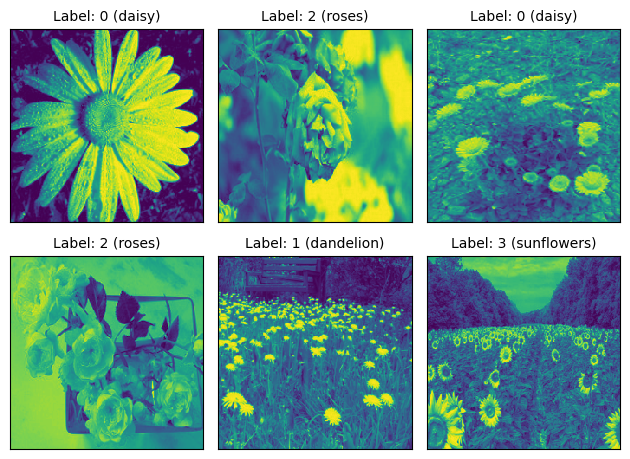

In [5]:
from PIL import Image

# Generating some samples from the dataloader
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Shape of the sample
"""
Interpreting the data - 
    16 : size of the train batch
    3 : Number of channels. Its 3 since its a color/RGB image
    256, 256 : Resolution of the image

"""
print(f"Shape of the example batch : {example_data.shape}")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)  
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title(f"Label: {example_targets[i]} ({classes[example_targets[i]]})", fontsize=10)
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()

## Make a prediction with the default MobileNet_V2 model without any finetuning

Predicted labels:


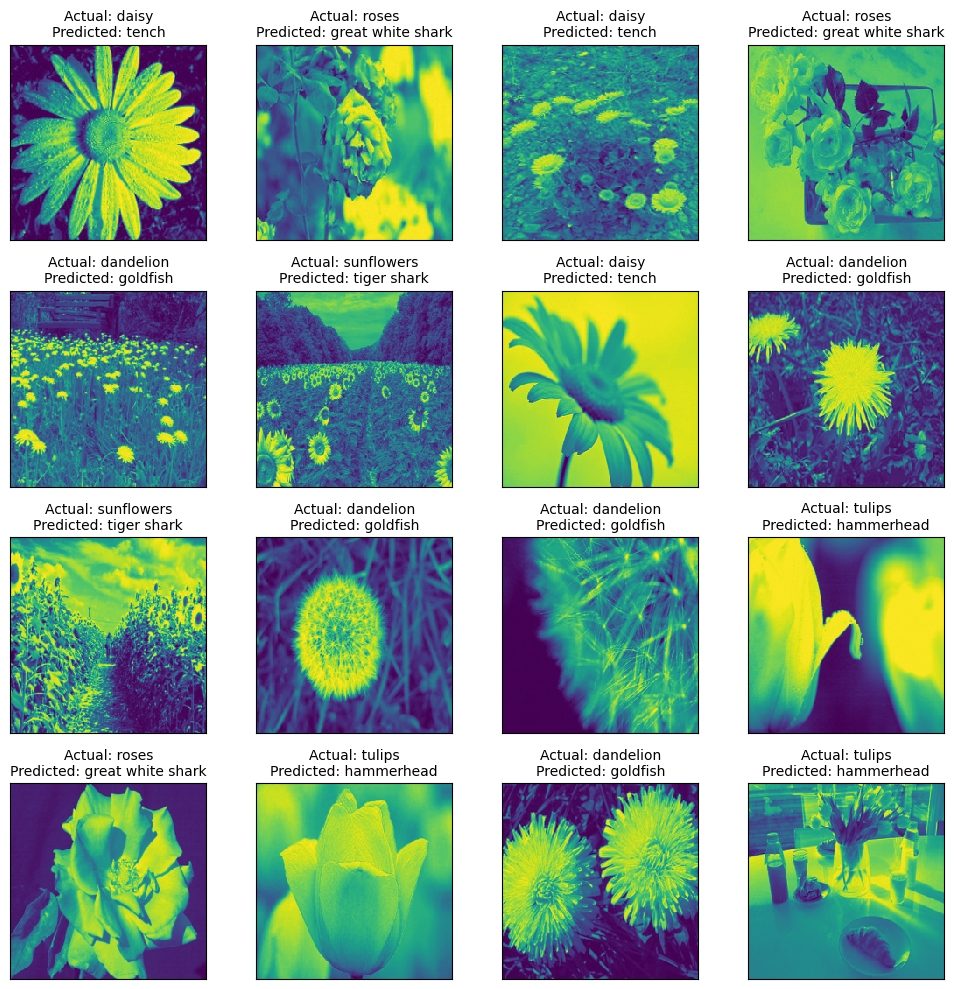

In [16]:
clf.eval()

with torch.no_grad():  # Disable gradient calculation for efficiency
    outputs = clf(example_data)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)

# Print proper labels
print("Predicted labels:")
plt.figure(figsize=(10,10))
for i in range(len(example_data)):
  label = image_labels[predicted_classes[i]]

  plt.subplot(4,4,i+1)  
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title(f"Actual: {classes[example_targets[i]]}\nPredicted: {label}", fontsize=10)
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()


It is quite evident that the default model is making poor quality predictions on our dataset. this is because the mobilenet model contains only daisy has a label out of the 1000 class labels. However, it still has been trained on 1 million+ images and has learned about different features of those images. This learning can be transferred to out new set of images. 

We will keep all layers of the model except the last one and retrain the model on our flower dataset. 

## Freezing all layers except the last classifier layer

We will take the classifier as our pretrained model. We do not need to train the layers again. All we need to do is to retrain the last layer of the classifier. To do that, we will remove the output layer of MobileNet_v2 and replace it with another layer that will give 5 outputs.

Note (Optional): In our case, we just need 5 classes as output. The model goes from 1280 inputs to 5 outputs, which is a huge drop. We will add another hidden layer that will take 1280 inputs and result in 100 outputs which would further be fed into the final output layer. We will also reuse the dropout layer from the existing model and will add a new ReLU activation after the hidden layer.

In [8]:
# Load the pre-trained MobileNetV2 model
model_tuned = clf

# Load pre-trained MobileNetV2, freezing all layers except the last classifier layer
for param in model_tuned.parameters():
    param.requires_grad = False  # Freeze all parameters except the last layer

# Modify the last layer for the number of flower classes
num_ftrs = model_tuned.classifier[1].in_features # we take index 1 since 0 is dropout layer

# Create the new hidden layer with 100 outputs
new_hidden_layer = torch.nn.Linear(num_ftrs, 100)

# Replace the existing classifier with a sequential container
model_tuned.classifier = torch.nn.Sequential(
    model_tuned.classifier[0],  # Reuse the dropout layer
    new_hidden_layer,        # Add the new hidden layer
    torch.nn.ReLU(),          # Activation for the hidden layer (optional, but often beneficial)
    torch.nn.Linear(100, len(classes))  # Final classification layer with len(classes) outputs
)

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(f"Updated layers: \n{model_tuned.classifier}")


Updated layers: 
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=5, bias=True)
)


## Train the model

In [9]:
def train(model, device, train_loader, optimizer, epoch, loss_criteria):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader, loss_criteria):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    

In [11]:
# Now use the train and test functions to train and test the model    
# Create an instance of the model class and allocate it to the device
model_tuned = model_tuned.to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model_tuned.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = torch.nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over defined epochs (in a real scenario, you'd likely use many more)
epochs = 3
for epoch in range(1, epochs + 1):
        train_loss = train(model_tuned, device, train_loader, optimizer, epoch, loss_criteria)
        test_loss = test(model_tuned, device, test_loader, loss_criteria)
        
        # Append metrics to the list
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Epoch: 1
Training set [0/2569 (0%)] Loss: 1.605063
Training set [160/2569 (6%)] Loss: 1.565671
Training set [320/2569 (12%)] Loss: 0.920484
Training set [480/2569 (19%)] Loss: 0.977056
Training set [640/2569 (25%)] Loss: 0.647996
Training set [800/2569 (31%)] Loss: 0.558229
Training set [960/2569 (37%)] Loss: 0.546876
Training set [1120/2569 (43%)] Loss: 0.674550
Training set [1280/2569 (50%)] Loss: 0.475857
Training set [1440/2569 (56%)] Loss: 0.373039
Training set [1600/2569 (62%)] Loss: 0.290426
Training set [1760/2569 (68%)] Loss: 0.470560
Training set [1920/2569 (75%)] Loss: 0.473189
Training set [2080/2569 (81%)] Loss: 0.552127
Training set [2240/2569 (87%)] Loss: 0.541298
Training set [2400/2569 (93%)] Loss: 0.856606
Training set [1440/2569 (99%)] Loss: 0.960952
Training set: Average loss: 0.711800
Validation set: Average loss: 0.324414, Accuracy: 984/1101 (89%)

Epoch: 2
Training set [0/2569 (0%)] Loss: 0.135794
Training set [160/2569 (6%)] Loss: 0.967924
Training set [320/2569

We can observe a drastic increase in accuracy after just 1 epoch (approx 89-90%). 

## Model Evaluation

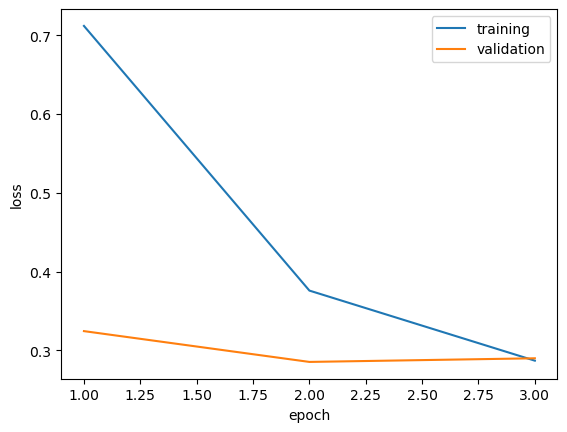

In [12]:
# Plot the training and validation losses over epochs
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


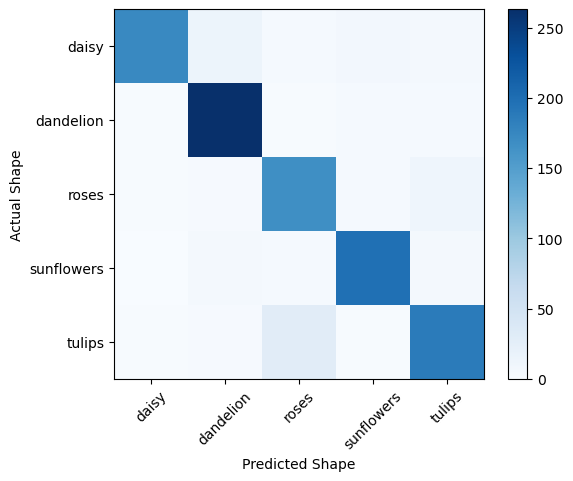

In [13]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model_tuned.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model_tuned.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Make Predictions on the examples dataset again using the trained model

We will use the same example set on which the pretrained model made a prediction (and did quite bad). Let us now use the tuned model on that dataset and see if there is any change in performance.

Predicted labels:


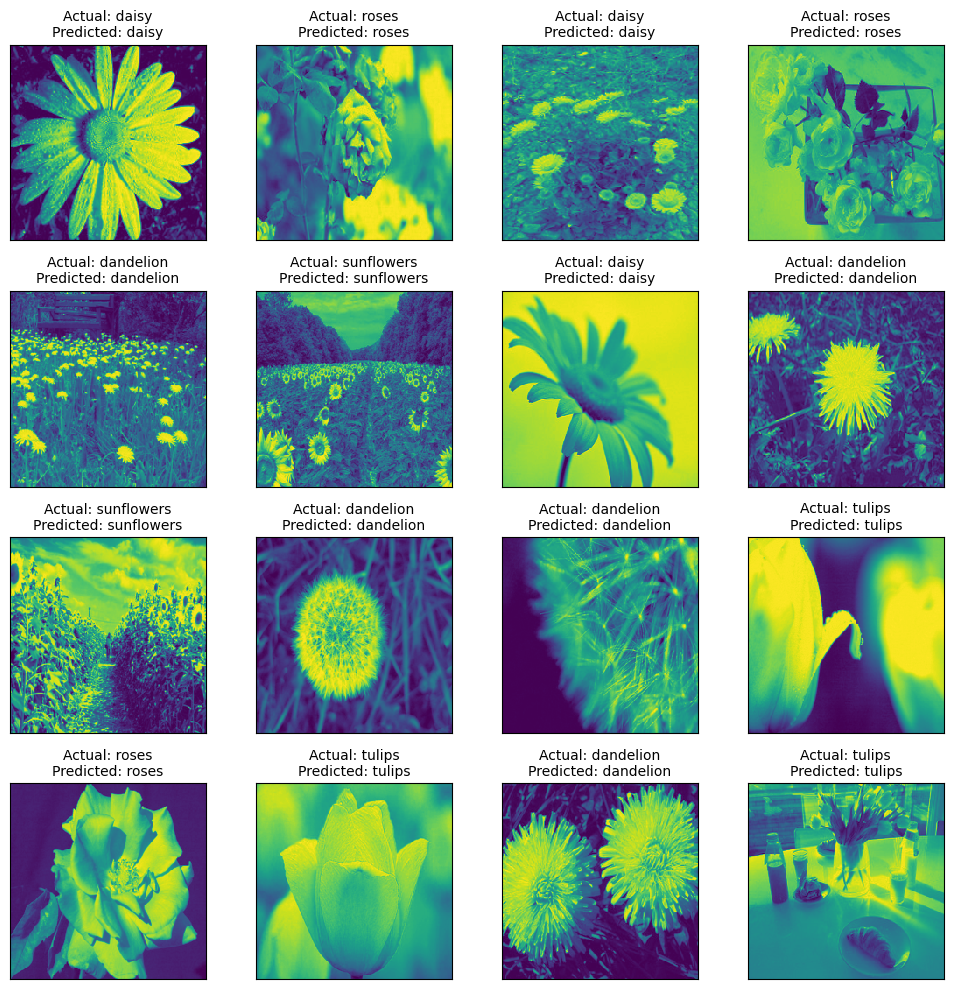

In [17]:
model_tuned.eval()

with torch.no_grad():  # Disable gradient calculation for efficiency
    outputs = model_tuned(example_data)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)

# Print proper labels
print("Predicted labels:")
plt.figure(figsize=(10,10))
for i in range(len(example_data)):
  # Get the actual and predicted labels
  pred_label = classes[predicted_classes[i]]
  actual_label = classes[example_targets[i]]

  # Create plot
  plt.subplot(4,4,i+1)  
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}", fontsize=10)
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()
